In [ ]:
!pip install --update matplotlib

# Aprendizaje basado en *Ensembles*


El aprendizaje basado en [*ensembles*](https://scikit-learn.org/stable/modules/ensemble.html) intenta buscar una sinergia entre distintos modelos de aprendizaje computacional. El término proviene del [ámbito musical](https://en.wikipedia.org/wiki/Musical_ensemble), en el cual varias bandas o solistas se agrupan con un nuevo nombre para tocar juntos.

La premisa es que un conjunto de expertos será capaz de ofrecer mejores predicciones que los expertos por separado. Esto se consigue complementando las carencias de un modelo con otros modelos.

Los métodos *ensemble* se distribuyen en cuatro grandes familias:

- **_Votting_**: diferentes clasificadores se juntan para determinar, mediante votación, qué etiqueta debe asignarse a una muestra.

- **_Bagging_**: se entrenan múltiples instancias de un mismo clasificador eliminando aleatoriamente en cada entrenamiento muestras y características de los datos.

- **_Boosting_**: los modelos del ensemble se construyen de manera iterativa, intentando reducir el sesgo de la combinación de todos.

- **_Stacking_**: las salidas de diferentes modelos predictivos son combinados por otro modelo predictivo que puede, opcionalmente, incluir también las características del conjunto de datos como entrada.

## *Voting Classifier*

La idea detrás de un ([`VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)) es combinar clasificadores conceptualmente diferentes y utilizar un voto mayoritario (*hard*) o las probabilidades promedio pronosticadas (*soft-voting*) para predecir las etiquetas. 

Este clasificador puede ser útil para un conjunto de modelos con un rendimiento igualmente bueno, a fin de equilibrar sus debilidades individuales.

Veamos el resultado de clasificar un conjunto de datos sintético con los clasificadores `DecisionTreeClassifier`, `KNeighborsClassifier` y `SVC`:

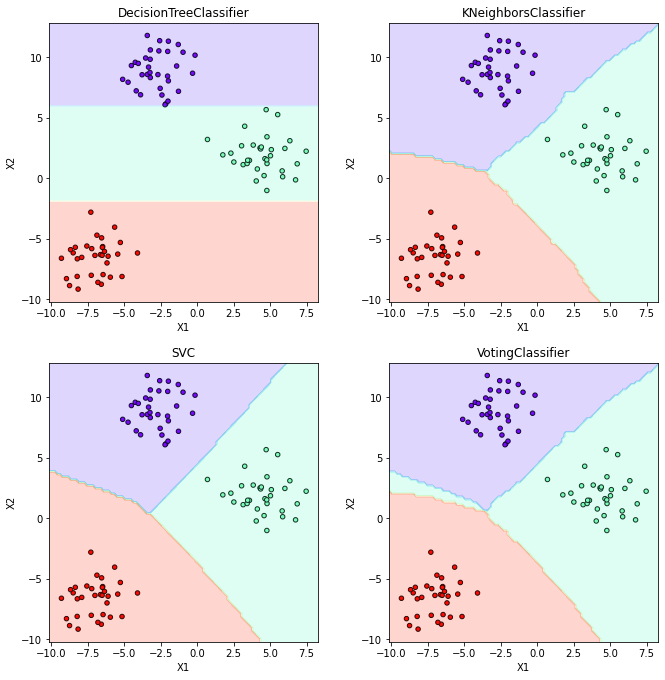

In [1]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import numpy as np

X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1.5, random_state=42)

clf1 = DecisionTreeClassifier(max_depth=4, random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True, random_state=42)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='hard', weights=[2, 1, 2])

clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)
eclf = eclf.fit(X, y)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.tight_layout(pad=4.0)

def plot_clf(clf, axs, title): 
    axs.set_title(title)
    
    axs.set_xlabel('X1')
    axs.set_ylabel('X2')
    
    axs.scatter(X[:,0], X[:,1], c=y, edgecolor='black', s=20, cmap='rainbow')
    
    xmin, xmax = axs.get_xlim()
    ymin, ymax = axs.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    grid_pred = clf.predict(grid).reshape(xx.shape)
    axs.contourf(xx, yy, grid_pred, alpha=0.2, vmin=0, vmax=2, cmap='rainbow')
    
plot_clf(clf1, axs[0,0], 'DecisionTreeClassifier')
plot_clf(clf2, axs[0,1], 'KNeighborsClassifier')
plot_clf(clf3, axs[1,0], 'SVC')
plot_clf(eclf, axs[1,1], 'VotingClassifier')

En el caso anterior hemos configurado el `VotingClassifier` especificando el parámetro `voting='hard'` por lo que la salida del clasificador será la opinión mayoritaria del resto de clasificadores.

Y ahora probamos con una configuración `voting='soft'`, que trabaja con las probabilidades de que la muestra pertenezca a una clase en lugar de con la clase directamente. Además, es posible modificar el peso de la probabilidad de cada clasificador mediante el parámetro `weights`.

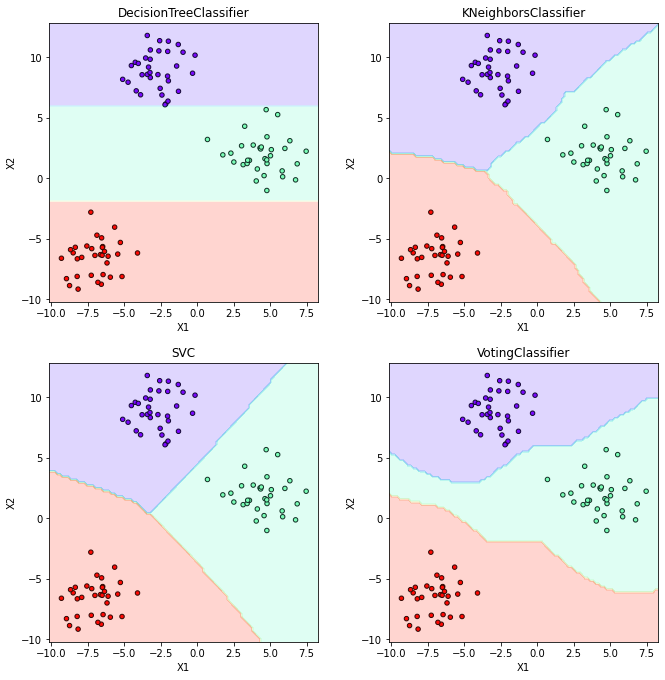

In [21]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import numpy as np

X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1.5, random_state=42)

clf1 = DecisionTreeClassifier(max_depth=4, random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True, random_state=42)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2, 1, 2])

clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)
eclf = eclf.fit(X, y)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.tight_layout(pad=4.0)

def plot_clf(clf, axs, title):
    axs.set_title(title)

    axs.set_xlabel('X1')
    axs.set_ylabel('X2')

    axs.scatter(X[:,0], X[:,1], c=y, edgecolor='black', s=20, cmap='rainbow')

    xmin, xmax = axs.get_xlim()
    ymin, ymax = axs.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    grid_pred = clf.predict(grid).reshape(xx.shape)
    axs.contourf(xx, yy, grid_pred, alpha=0.2, vmin=0, vmax=2, cmap='rainbow')

plot_clf(clf1, axs[0,0], 'DecisionTreeClassifier')
plot_clf(clf2, axs[0,1], 'KNeighborsClassifier')
plot_clf(clf3, axs[1,0], 'SVC')
plot_clf(eclf, axs[1,1], 'VotingClassifier')

## Bagging Classifier

El funcionamiento de estos métodos consiste en entrenar varias instancias de un mismo modelo de aprendizaje computacional, pero usando un subconjunto distinto de muestras seleccionadas aleatoriamente para cada entrenamiento.

En `sklearn` tenemos el meta-clasificador [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier). Destacamos algunos de sus parámetros:

- `base_estimator`: estimador sobre el que realizar los múltiples entrenamientos.
- `n_estimators`: permite definir el número de muestreos a ejecutar sobre el clasificador especificado.
- `max_samples`: porcentaje (o número) de muestras a utilizar en cada muestreo.
- `max_features`: porcentaje (o número) de features a utilizar en cada muestreo.

Veamos su funcionamiento empleando `KNeighborsClassifier` como estimador base y empleando el 5% de las muestras en cada entrenamiento.

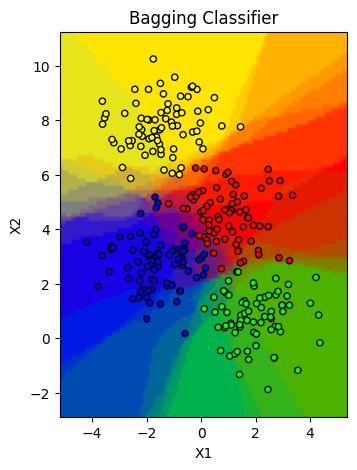

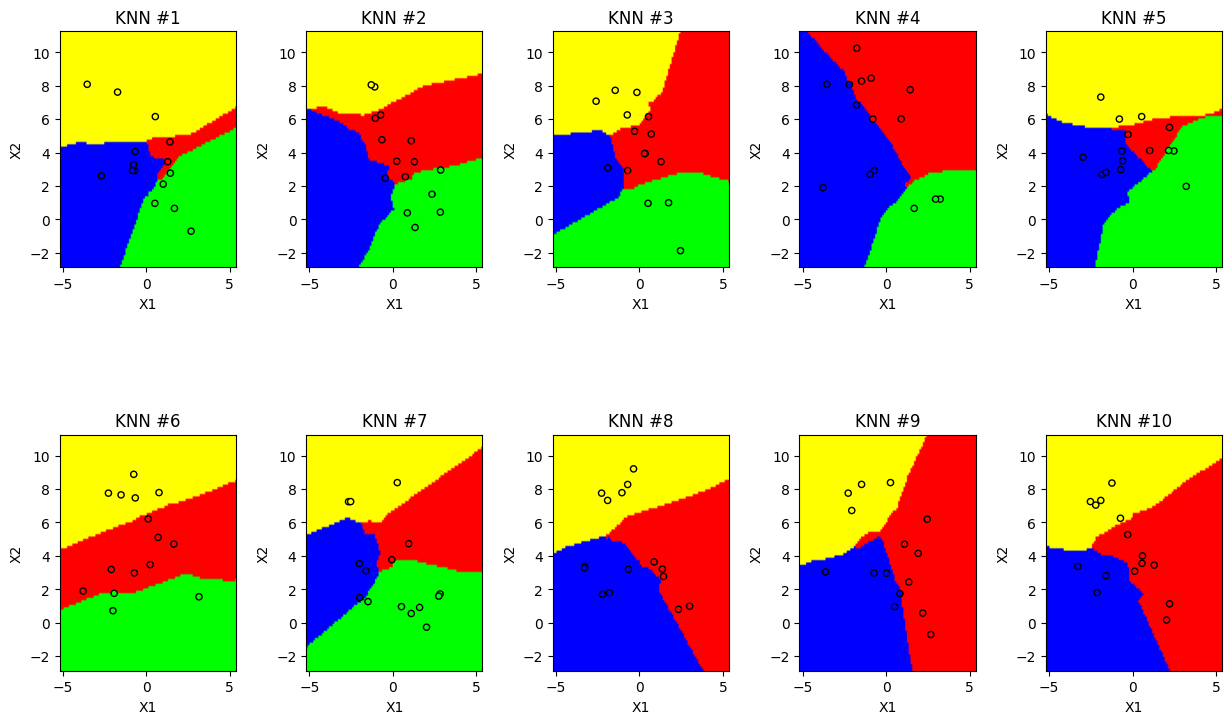

In [2]:
from clustervis import ensemble_classifier_plot, base_classifier_plot

import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]

resolution = 100

percentageSelected = 0.05

clf = KNeighborsClassifier(n_neighbors=3)
bag = BaggingClassifier(clf, n_estimators=10, max_samples=percentageSelected, random_state=1)
bag.fit(X, y)

fig_ensemble, ax_ensemble = plt.subplots(figsize=(10, 5))

ensemble_classifier_plot(X, bag, colors, resolution, 'Bagging Classifier', show=True, ax=ax_ensemble)

n_knns = len(bag.estimators_)

fig, axes = plt.subplots(2, 5, figsize=(15, 10))

axes = axes.flatten()

for i, base_estimator in enumerate(bag.estimators_):
    base_classifier_plot(X, base_estimator, colors, resolution, f'KNN #{i+1}', show=False, ax=axes[i], percentageSelected=percentageSelected)

plt.subplots_adjust(wspace=0.4, hspace=0.1)

plt.show()

## Boosting

Los modelos de Boosting buscan encadenar diferentes estimadores debiles de tal forma que cada modelo aprenda a partir de la salida del anterior.

### AdaBoost

El principio básico de AdaBoost es ajustar una secuencia de aprendizajes débiles (es decir, modelos que sólo son ligeramente mejores que una clasificación aleatoria) usando versiones modificadas de los datos. Las predicciones de todos ellos se combinan finalmente mediante una votación por mayoría ponderada (o suma) para producir la predicción final. 

Las modificaciones de los datos en cada una de las iteraciones consisten en aplicar pesos $w_1, w_2, \dots, w_n$ a cada una de las $n$ muestras de entrenamiento. Inicialmente, estos pesos se fijan a $w_i=\frac{1}{n}$, de tal modo que en la primera iteración se produce un entrenamiento "débil" de los datos originales. En cada iteración sucesiva, los pesos de la muestra se modifican individualmente y el algoritmo de aprendizaje se vuelve a aplicar a los datos re-ponderados. En un paso determinado, los ejemplos de entrenamiento que fueron incorrectamente predichos por el modelo del paso anterior aumentan sus pesos, mientras que los pesos se reducen para los que fueron predichos correctamente. A medida que avanzan las iteraciones, los ejemplos difíciles de predecir reciben una influencia cada vez mayor, logrando, de este modo, que los clasificadores se concentren en las muestras que no han sido correctamente clasificadas.

`sklearn` nos proporciona la clase [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier).

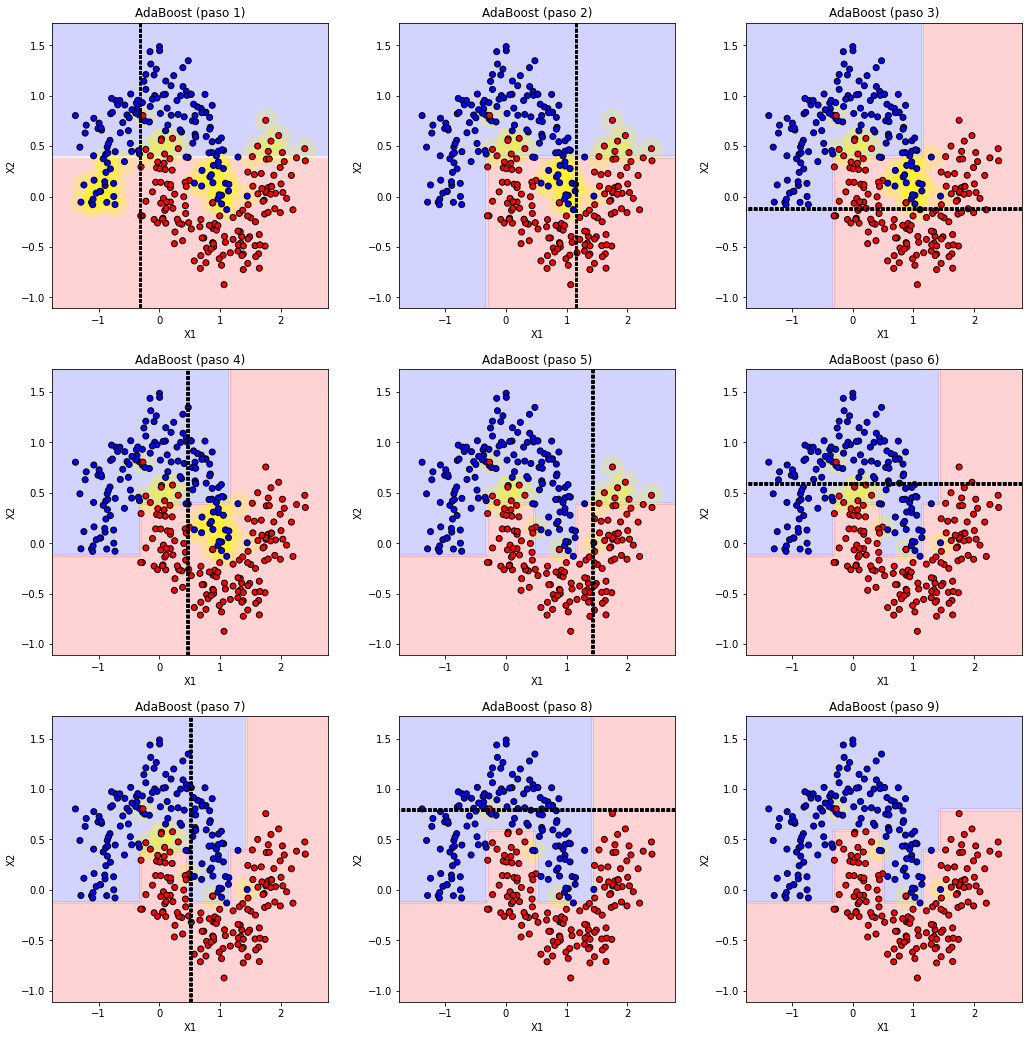

In [4]:
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier

X, y = make_moons(n_samples=300, noise=0.20, random_state=1337)

min, max = np.amin(X, axis=0), np.amax(X, axis=0)
diff = max - min
min, max = min - 0.1 * diff, max + 0.1 * diff

xx, yy = np.meshgrid(np.linspace(min[0], max[0], 100), np.linspace(min[1], max[1], 100))
grid = np.c_[xx.ravel(), yy.ravel()]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.tight_layout(pad=4.0)

for i in range(9):
    
    row = int(i / 3)
    col = i % 3
        
    axs[row,col].set_title('AdaBoost (paso ' + str(i+1) + ')')
    
    axs[row,col].set_xlabel('X1')
    axs[row,col].set_ylabel('X2')

    axs[row,col].set_xlim(min[0], max[0])
    axs[row,col].set_ylim(min[1], max[1])
        
    n_estimators = i+1
    
    adaboost = AdaBoostClassifier(n_estimators=n_estimators, random_state=42).fit(X, y)
    
    grid_pred = adaboost.predict(grid).reshape(xx.shape)
    axs[row,col].contourf(xx, yy, grid_pred, alpha=0.2, cmap='bwr')
    
    wrong = X[adaboost.predict(X) != y]
    axs[row,col].scatter(wrong[:,0], wrong[:,1], c='yellow', s=500, alpha=0.2)

    axs[row,col].scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='black')

    if i < 8:
        adaboost_next = AdaBoostClassifier(n_estimators=n_estimators+1, random_state=42).fit(X, y)

        clf = adaboost_next.estimators_[n_estimators]
        grid_pred_next = clf.predict(grid).reshape(xx.shape)    
        axs[row,col].contour(xx, yy, grid_pred_next, linewidths=1, linestyles='dashed', colors='black')
    
    

### Gradient Boosting

Gradient Boosting es una generalización del algoritmo AdaBoost, con la diferencia de que éste permite emplear cualquier función de coste siempre y cuando sea derivable. Existen múltiples implementaciones de Gradient Boosting (XGBoost, CatBoost, LightGMB, etc.), pero la idea general de todas ellas es la misma: los modelos son entrenados de forma secuencia, de forma que cada modelo ajusta los errores (llamados residuos) del modelo anterior.

Formalmente, Gradient Boosting ajusta un primer modelo débil (con *underfitting*)

$$
f_1(x) \approx y
$$

Sucesivamente, va ajustando otros modelos que aprenden a partir de los residuos del anterior

$$
f_2(x) \approx y - f_1(x)
$$

$$
f_3(x) \approx y - f_1(x) - f_2(x)
$$

$$
\dots
$$

$$
f_k(x) \approx y - \left( \sum_{i=1}^{k-1} f_i(x) \right)
$$

El cálculo de los residuos implica que las predicciones del modelo sean valores continuos (modelos de regresión). Para aplicarlo a clasificación se conviene estima la probabilidad de pertenencia a una clase como salida del modelo.

El aprendizaje del modelo, por tanto, implica definir una función de perdida que permita ir mejorando las sucesivas $f_i(x)$ hacia un mínimo absoluto:

$$
F(x) = \sum_{i=1}^k f_i(x)
$$

$$
L_{MSE} = \frac{1}{n} (y - F(x))^2
$$

$$
\frac{\partial L_{MSE}}{\partial F} = - \frac{2}{n} (y - F(x)) = \frac{2}{n}F_i(x)
$$


El problema de Gradient Boosting es que tiende a realizar *overfitting*, por lo que se añade un parámetro $\lambda$ de factor de aprendizaje (*learning rate*) para atenuar este efecto:


$$
f_2(x) \approx y - \lambda \cdot f_1(x)
$$

$$
f_3(x) \approx y - \lambda \cdot f_1(x) - \lambda \cdot f_2(x)
$$

$$
\dots
$$

$$
f_k(x) \approx y - \lambda \cdot \left( \sum_{i=1}^{k-1} f_i(x) \right)
$$

Veamos su funcionamiento con [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) de `sklearn`:

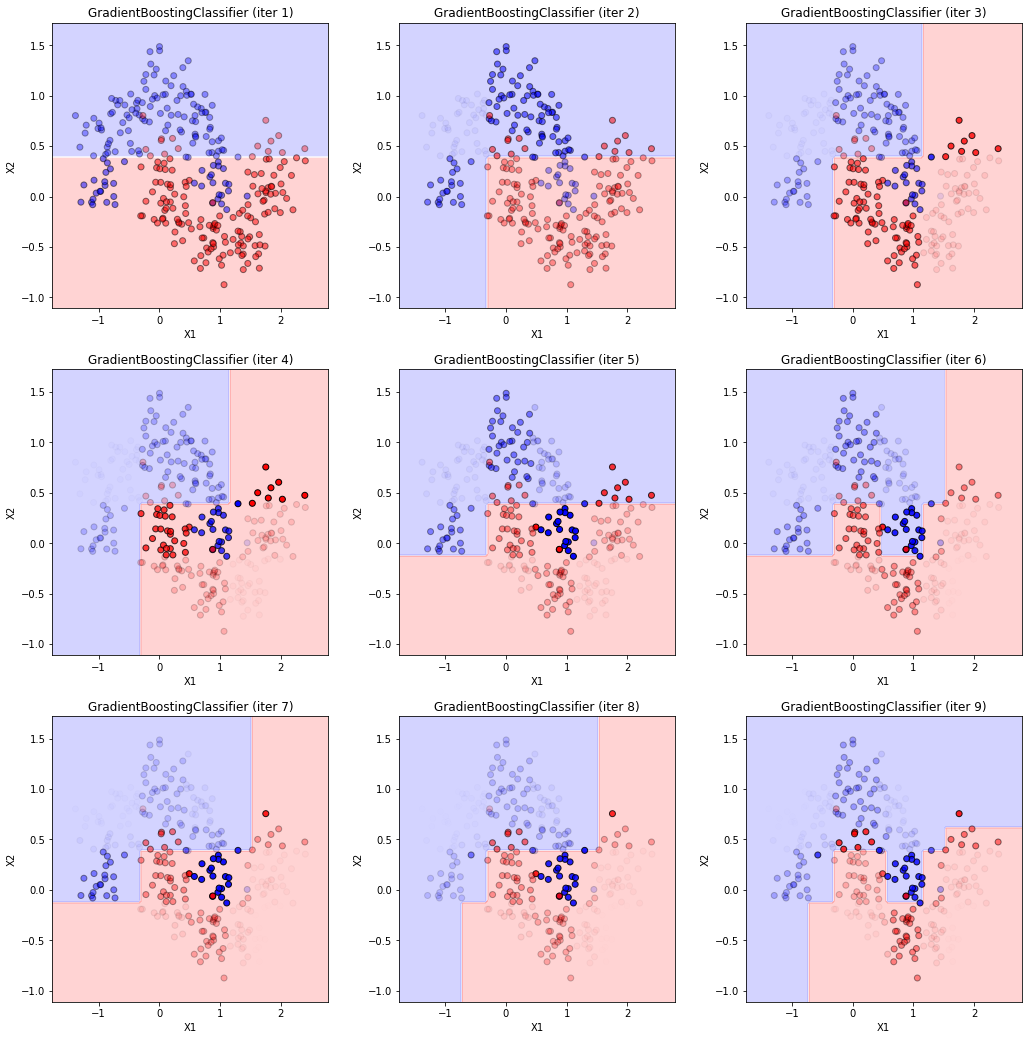

In [16]:
# requiere matplotlib 3.4.x

from sklearn.datasets import make_moons
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_moons(n_samples=300, noise=0.20, random_state=1337)

min, max = np.amin(X, axis=0), np.amax(X, axis=0)
diff = max - min
min, max = min - 0.1 * diff, max + 0.1 * diff

xx, yy = np.meshgrid(np.linspace(min[0], max[0], 100), np.linspace(min[1], max[1], 100))
grid = np.c_[xx.ravel(), yy.ravel()]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.tight_layout(pad=4.0)

for i in range(9):
    
    row = int(i / 3)
    col = i % 3
        
    axs[row,col].set_title('GradientBoostingClassifier (iter ' + str(i+1) + ')')
    
    axs[row,col].set_xlabel('X1')
    axs[row,col].set_ylabel('X2')

    axs[row,col].set_xlim(min[0], max[0])
    axs[row,col].set_ylim(min[1], max[1])
        
    n_estimators = i+1
    
    gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, criterion='mse', max_depth=1, random_state=42).fit(X, y)
    
    grid_pred = gb.predict(grid).reshape(xx.shape)
    axs[row,col].contourf(xx, yy, grid_pred, alpha=0.2, cmap='bwr')
    
    alpha = 1 - 2 * np.absolute(gb.predict_proba(X)[:,0] - 0.5)
    axs[row,col].scatter(X[:,0], X[:,1], c=y, alpha=alpha, cmap='bwr', edgecolor='black')

## Stacked generalization

*Stacked generalization* es un método para combinar los estimadores para reducir sus sesgos. Concretamente, las predicciones de cada estimador individual se apilan y se usan como entrada a un estimador final para calcular la predicción. Este estimador final es entrenado a través de la validación cruzada.

El estimador final generalmente se alimenta únicamente de la salida de los clasificadores previos:

![Stacked generalization sin features](https://wolpert.readthedocs.io/en/latest/_images/stack_example_001.png)

No obstante, también es posible añadir a dicho estimador las muestras del conjunto de datos:

![Stacked generalization con features](https://wolpert.readthedocs.io/en/latest/_images/restack_graph.png)

En `sklearn` tenemos este clasificador implementado en la clase [`StackingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier). Los estimadores a combinar se deben definir en el parámetro `estimators` mientras que el estimador final se define en el parametro `final_estimator`. El parámetro `passthrough` permite definir si el estimador final se entrena sólo con la salida de los estimadores (`passthrough=False`, valor por defecto) o se usan también las muestras de entrada (`passthrough=True`).


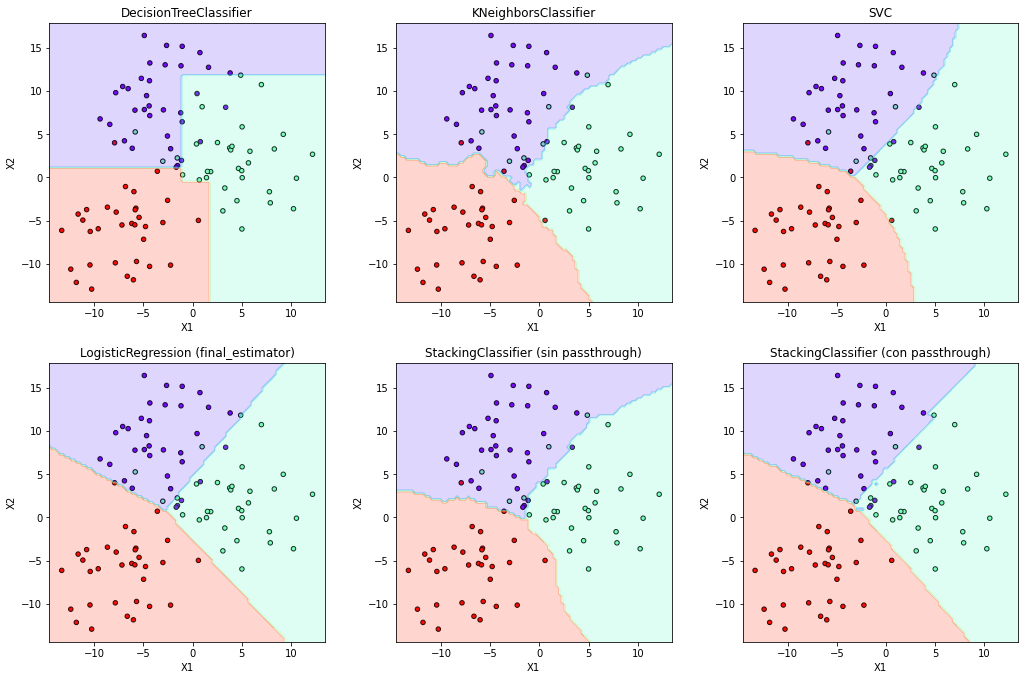

In [8]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import numpy as np

X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=4, random_state=42)

clf1 = DecisionTreeClassifier(max_depth=4, random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True, random_state=42)

lr = LogisticRegression(random_state=42)

estimators = [('dt', clf1), ('knn', clf2), ('svc', clf3)]

sclf_pass_false = StackingClassifier(estimators=estimators, passthrough=False)
sclf_pass_true = StackingClassifier(estimators=estimators, passthrough=True)

clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)

lr = lr.fit(X, y)

sclf_pass_false = sclf_pass_false.fit(X, y)
sclf_pass_true = sclf_pass_true.fit(X, y)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.tight_layout(pad=4.0)

def plot_clf(clf, axs, title): 
    axs.set_title(title)
    
    axs.set_xlabel('X1')
    axs.set_ylabel('X2')
    
    axs.scatter(X[:,0], X[:,1], c=y, edgecolor='black', s=20, cmap='rainbow')
    
    xmin, xmax = axs.get_xlim()
    ymin, ymax = axs.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    grid_pred = clf.predict(grid).reshape(xx.shape)
    axs.contourf(xx, yy, grid_pred, alpha=0.2, cmap='rainbow')
    
plot_clf(clf1, axs[0,0], 'DecisionTreeClassifier')
plot_clf(clf2, axs[0,1], 'KNeighborsClassifier')
plot_clf(clf3, axs[0,2], 'SVC')

plot_clf(lr, axs[1,0], 'LogisticRegression (final_estimator)')
plot_clf(sclf_pass_false, axs[1,1], 'StackingClassifier (sin passthrough)')
plot_clf(sclf_pass_true, axs[1,2], 'StackingClassifier (con passthrough)')


---

Creado por **Raúl Lara** (raul.lara@upm.es) y **Fernando Ortega** (fernando.ortega@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">